# Sequence-to-sequence Tensorflow model for Amazon reviews

This notebook walks through training a [Sequence to sequence model](https://www.tensorflow.org/tutorials/seq2seq) with Tensorflow (version 1.1).

The model is currently used as the predictive backend for the SUMZ chrome extension, which takes in Amazon reviews on the current web page and displays a small summary of each review. The model is trained on the the [Amazon fine food reviews dataset.](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Kaggle, which consists of 568K review-summary pairs.

This notebook goes through the following:
- Building a sequence-to-sequence model using Tensorflow
- Using the preprocessed data from the data_preprocessing notebook to train the model
- Exporting the model into ProtoBuff format for serving in a production environment

This builds on the [Text Summarization](https://github.com/Currie32/Text-Summarization-with-Amazon-Reviews) project by David Currie (this [Medium post](https://medium.com/towards-data-science/text-summarization-with-amazon-reviews-41801c2210b) goes into excellent detail as well).

In [1]:
import pickle
import time
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from tensorflow.contrib.rnn import GRUCell, LSTMCell

In [23]:
def model_input_placeholders():
    """
    Create model input placeholders
    : return: placeholder tensors
    """    
    inputs = tf.placeholder(tf.int32, [None,None], name='input')
    targets = tf.placeholder(tf.int32, [None,None])
    learning_rate = tf.placeholder(tf.float32)
    keep_probability = tf.placeholder(tf.float32, name='keep_probability')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    max_target_seq_len = tf.reduce_max(target_seq_len, name='max_target_seq_len')
    source_seq_len = tf.placeholder(tf.int32, (None,), name='source_seq_len')
    
    return inputs, targets, learning_rate, keep_probability, target_seq_len, max_target_seq_len, source_seq_len

In [47]:
def embedded_encoder_input(input_data, word_embedding_matrix):
    return tf.nn.embedding_lookup(word_embedding_matrix, input_data)

def encoding_layer(encoder_inputs, rnn_size, 
                   source_seq_len, num_layers, 
                   keep_prob, 
                   encoder_style, 
                   base_cell):
    """
    Works with bidirectional and regular (unidirectional RNN)
    as specificed by the 'encoder_style' parameter that can be either
    'bidirectional_rnn' or 'unidirectional_rnn'
    
    Also can be passed in either a LSTMCell or GRUCell for 'LSTMCell' param
    """

    if encoder_style == 'unidirectional_rnn':
        print("UNIDIRECTIONAL ENCODER")
        print("ENCODER BASE CELL IS", base_cell)
        def make_cell(rnn_size):
            if base_cell == 'LSTM':
                enc_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2))
                enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=keep_prob)
            else:
                enc_cell = tf.contrib.rnn.GRUCell(rnn_size)
                enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=keep_prob)           
            return enc_cell
        enc_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
        enc_output, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                  encoder_inputs, 
                                                  sequence_length=source_seq_len, 
                                                  dtype=tf.float32)
        
    else:
        print("BIDRECTIONAL ENCODER")
        print("ENCODER BASE CELL IS", base_cell)
        for layer in range(num_layers):
            with tf.variable_scope('encoder_{}'.format(layer)):
                
                if base_cell =='LSTM':
                    fwCell = tf.contrib.rnn.LSTMCell(num_units = rnn_size,
                                                      initializer = tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                    bwCell = tf.contrib.rnn.LSTMCell(num_units = rnn_size,
                                                      initializer = tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                else:
                    fwCell = tf.contrib.rnn.GRUCell(num_units = rnn_size)
                    bwCell = tf.contrib.rnn.GRUCell(num_units = rnn_size)
                
#                 fwCell = base_cell(rnn_size)
#                 bwCell = base_cell(rnn_size)
                single_rnn_cell_forward = tf.contrib.rnn.DropoutWrapper(cell = fwCell,
                                                                        output_keep_prob = keep_prob)
                single_rnn_cell_backward = tf.contrib.rnn.DropoutWrapper(cell = bwCell,
                                                                         output_keep_prob = keep_prob)
                enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(single_rnn_cell_forward,
                                                                        single_rnn_cell_backward,
                                                                        encoder_inputs,
                                                                        source_seq_len,
                                                                        dtype = tf.float32)
        enc_output = tf.concat(enc_output, 2) # Concatenate both outputs together
        
    return enc_output, enc_state

In [25]:
def process_decoder_input(target_data, vocab_to_int, batch_size):

    # Remove the last word (integer) from each target sequence
    ending = tf.strided_slice(target_data, [0,0], [batch_size,-1], [1,1])
    
    # Add the <GO> token to each target sequence
    decoder_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)
    
    return decoder_input

In [26]:
def embedded_decoder_input(input_data, word_embedding_matrix):
    return tf.nn.embedding_lookup(word_embedding_matrix, input_data)

In [48]:
def make_decoder_cell(rnn_size, 
                      num_layers, 
                      encoder_output, 
                      source_seq_len, 
                      keep_prob,
                      batch_size,
                      encoder_state, 
                      attention, 
                      base_cell):

    """
    Works with either GRU or basic LSTM cells, as 'GRUCell' or 'BasicLSTM'
    for the 'cell_style' parameter
    
    Also works with or without Attention mechanism, as specified by the
    'attention' parameter
    
    [@TODO Allow different attention mechanisms for comparison]
    """    
    print("DECODER BASE CELL", base_cell)
    if attention == True:
        print("DECODER ATTENTOIN IS TRUE")
        for layer in range(num_layers):
            with tf.variable_scope('decoder_{}'.format(layer)):
                if base_cell =='LSTM':
                    single_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                                  initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
#                     dec_cell = tf.contrib.rnn.DropoutWrapper(single_cell, input_keep_prob=keep_prob)
                else:
                    single_cell = tf.contrib.rnn.GRUCell(rnn_size)
                dec_cell = tf.contrib.rnn.DropoutWrapper(single_cell, input_keep_prob=keep_prob)                    
                    
#                     dec_cell = tf.contrib.rnn.DropoutWrapper(base_cell(rnn_size), output_keep_prob=keep_prob)


        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                                   encoder_output,
                                                                   source_seq_len,
                                                                   normalize=False,
                                                                   name='BahdanauAttention')

        dec_cell = tf.contrib.seq2seq.DynamicAttentionWrapper(dec_cell,
                                                              attention_mechanism,
                                                              rnn_size)

        initial_state = tf.contrib.seq2seq.DynamicAttentionWrapperState(encoder_state[0],
                                                                        _zero_state_tensors(rnn_size, 
                                                                                            batch_size, 
                                                                                            tf.float32))
    
    else:
        print("DECODER ATTENTION IS FALSE")
        def make_cell(rnn_size):
            if base_cell == 'LSTM':
                dec_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2))
                dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
            else:
                dec_cell = tf.contrib.rnn.GRUCell(rnn_size)
                dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)           
            return dec_cell            
#             return tf.contrib.rnn.DropoutWrapper(base_cell(rnn_size), output_keep_prob=keep_prob)

        dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
        initial_state = encoder_state
        
    return dec_cell, initial_state 
    

In [49]:
def decoding_layer(input_data,
                   word_embedding_matrix,
                   num_layers, 
                   rnn_size, 
                   keep_prob, 
                   encoder_output, 
                   source_seq_len,
                   encoder_state,
                   batch_size,
                   vocab_size,
                   target_seq_len,
                   max_target_seq_len,
                   vocab_to_int,
                   attention,
                   base_cell):
    
    decoder_embedded_input = embedded_decoder_input(input_data, word_embedding_matrix)
    decoder_cell, initial_state = make_decoder_cell(rnn_size, 
                                                    num_layers, 
                                                    encoder_output, 
                                                    source_seq_len, 
                                                    keep_prob, 
                                                    batch_size,
                                                    encoder_state,
                                                    attention=attention,
                                                    base_cell=base_cell
                                                   )
    
    output_layer = Dense(vocab_size,
                        kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))

    # Training
    with tf.variable_scope("decode"):
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_embedded_input,
                                                            sequence_length = target_seq_len,
                                                            time_major=False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell,
                                                           training_helper,
                                                           initial_state,
                                                           output_layer)
        training_logits, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                               output_time_major=False,
                                                               impute_finished=True,
                                                               maximum_iterations=max_target_seq_len)
    
    with tf.variable_scope("decode", reuse=True): # Reuse same params for inference
        
        start_tokens = tf.tile(tf.constant([vocab_to_int['<GO>']], dtype=tf.int32), 
                               [batch_size], 
                               name='start_tokens')
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(word_embedding_matrix,
                                                                    start_tokens,
                                                                    vocab_to_int['<EOS>'])
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell,
                                                            inference_helper,
                                                            initial_state,
                                                            output_layer)
        inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                              output_time_major=False,
                                                              impute_finished=True,
                                                              maximum_iterations=max_target_seq_len)
    
    return training_logits, inference_logits

In [50]:
def full_seq2seq(input_data, 
                 word_embedding_matrix,
                 rnn_size,
                 source_seq_len,
                 num_layers,
                 keep_prob,
                 target_data,
                 vocab_to_int,
                 batch_size,
                 vocab_size,
                 target_seq_len,
                 max_target_seq_len,
                 encoder_style,
                 attention,
                 base_cell
                 ):
    

    
    # Encoding layer
    encoder_inputs = embedded_encoder_input(input_data, word_embedding_matrix)
    encoder_output, encoder_state = encoding_layer(encoder_inputs, 
                                                   rnn_size, 
                                                   source_seq_len, 
                                                   num_layers, 
                                                   keep_prob,
                                                   encoder_style=encoder_style,
                                                   base_cell=base_cell)
    
    # Decoding layer
    processed_decoder_input = process_decoder_input(target_data, 
                                                    vocab_to_int, 
                                                    batch_size)
    training_logits, inference_logits = decoding_layer(processed_decoder_input,
                                                       word_embedding_matrix,
                                                       num_layers, 
                                                       rnn_size, 
                                                       keep_prob, 
                                                       encoder_output, 
                                                       source_seq_len,
                                                       encoder_state,
                                                       batch_size,
                                                       vocab_size,
                                                       target_seq_len,
                                                       max_target_seq_len,
                                                       vocab_to_int,
                                                       attention=attention,
                                                       base_cell=base_cell)
    return training_logits, inference_logits

In [51]:
def pad_batch(batch_to_pad):
    max_size = max([len(item) for item in batch_to_pad])
    padded_batch = [item + [vocab_to_int['<PAD>']] * (max_size - len(item)) for item in batch_to_pad]
    return padded_batch

def get_batches(summaries, reviews, batch_size):
    for batch_i in range(0, len(reviews)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        reviews_batch = reviews[start_i:start_i + batch_size]
        pad_summaries_batch = pad_batch(summaries_batch)
        pad_reviews_batch = pad_batch(reviews_batch)
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        pad_reviews_lengths = []
        for review in pad_reviews_batch:
            pad_reviews_lengths.append(len(review))
        
        yield pad_summaries_batch, pad_reviews_batch, pad_summaries_lengths, pad_reviews_lengths
        

In [52]:
# Hyperparameters
epochs = 10
rnn_size = 256
batch_size = 64
num_layers = 2
lr = 0.001
keep_prob = 0.75

In [87]:
def build_and_train_model(word_embedding_matrix, 
                rnn_size,
                num_layers,
                keep_probability,
                vocab_to_int,
                batch_size,
                sorted_summaries,
                sorted_reviews,
                encoder_style='unidirectional_rnn',
                attention=True,
                base_cell='LSTM',
                checkpoint_file='./model_checkpoints/best_model.ckpt',
                losses_arr_path='./checkpointed_data/losses/LOSS_ARR.p'):
    

    # GRAPH BUILDING
    train_graph = tf.Graph()
    with train_graph.as_default():
        
        # Model inputs
        inputs, targets, learning_rate, keep_probability, target_seq_len, max_target_seq_len, source_seq_len = model_input_placeholders()
        
        # Create final logits tensors
        training_logits, inference_logits = full_seq2seq(tf.reverse(inputs, [-1]),
                                                         word_embedding_matrix,
                                                         rnn_size,
                                                         source_seq_len,
                                                         num_layers,
                                                         keep_probability,
                                                         targets,
                                                         vocab_to_int,
                                                         batch_size,
                                                         len(vocab_to_int)+1,
                                                         target_seq_len,
                                                         max_target_seq_len,                  
                                                         encoder_style=encoder_style,
                                                         attention=attention,
                                                         base_cell=base_cell)

        training_logits = tf.identity(training_logits.rnn_output, 'logits')
        inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
        
        masks = tf.sequence_mask(target_seq_len, max_target_seq_len, dtype=tf.float32, name='masks')
        
        # Set up optimizer
        with tf.name_scope("optimization"):
            
            cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                                    targets,
                                                    masks)
            
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            gradients = optimizer.compute_gradients(cost)
            capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
            train_operation = optimizer.apply_gradients(capped_gradients)

     
    
    start = 200000
    end = start + 50000
    sorted_summaries_short = sorted_summaries[start:end]
    sorted_reviews_short = sorted_reviews[start:end]
    
    display_step = 20 # Check training loss after every 20 batches
    stop = 10 # Stop training if average loss doesn't decrease in this mean update_checks
    per_epoch = 5 # update checks per epoch
    update_check = (len(sorted_reviews_short)//batch_size//per_epoch)-1

    update_loss = 0 
    batch_loss = 0
    summary_update_loss = [] # Record the update losses for saving improvements in the model
    avg_update_loss = [] # Record avg updates, for charting
    batch_infos = [] # losses and times for each batch, for charting

    checkpoint = checkpoint_file
    
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(1, epochs+1):
            update_loss = 0
            batch_loss = 0
            for batch_i, (summaries_batch, reviews_batch, summaries_lengths, reviews_lengths) in enumerate(
                    get_batches(sorted_summaries_short, sorted_reviews_short, batch_size)):
                start_time = time.time()
                _, loss = sess.run(
                    [train_operation, cost],
                    {inputs: reviews_batch,
                     targets: summaries_batch,
                     learning_rate: lr,
                     target_seq_len: summaries_lengths,
                     source_seq_len: reviews_lengths,
                     keep_probability: keep_prob})

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time
                batch_infos.append((round(loss,3),round(batch_time,3)))
#                 print(batch_infos)

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(sorted_reviews_short) // batch_size, 
                                  batch_loss / display_step, 
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3), end="")
                    summary_update_loss.append(update_loss)
#                     avg_update_loss.append(round(update_loss/update_check,3))
#                     print("DUMPING TO", losses_arr_path)
#                     pickle.dump(avg_update_loss, open(losses_arr_path, 'wb'))
                    pickle.dump(batch_infos, open(losses_arr_path, 'wb'))

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print(' -- New Record!') 
                        stop_early = 0
                        saver = tf.train.Saver() 
                        saver.save(sess, checkpoint)

                    else:
                        print("-- No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0
    print("\n=====Finished training!\n")


In [54]:
def load_pickled_data():
    word_dicts_path = './checkpointed_data/word_dicts.p'
    model_input_data_path = './checkpointed_data/model_input_data.p'
    vocab_to_int, int_to_vocab, word_embedding_matrix = pickle.load(open(word_dicts_path, mode='rb'))
    sorted_summaries, sorted_reviews = pickle.load(open(model_input_data_path, mode='rb'))
    return vocab_to_int, int_to_vocab, word_embedding_matrix, sorted_summaries, sorted_reviews

In [40]:
vocab_to_int, int_to_vocab, word_embedding_matrix, sorted_summaries, sorted_reviews = load_pickled_data()

In [94]:
LSTM_UNI_ATTN_CHECKPOINTDIR = './model_checkpoints/LSTM_UNI_ATTN/best_model.ckpt'
LSTM_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_ATTN_LOSS_ARR.p'
GRU_UNI_ATTN_CHECKPOINTDIR = './model_checkpoints/GRU_UNI_ATTN/best_model.ckpt'
GRU_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_ATTN_LOSS_ARR.p'
LSTM_BI_ATTN_CHECKPOINTDIR = './model_checkpoints/LSTM_BI_ATTN/best_model.ckpt'
LSTM_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_ATTN_LOSS_ARR.p'
GRU_BI_ATTN_CHECKPOINTDIR = './model_checkpoints/GRU_BI_ATTN/best_model.ckpt'
GRU_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_ATTN_LOSS_ARR.p'

LSTM_UNI_CHECKPOINTDIR = './model_checkpoints/LSTM_UNI/best_model.ckpt'
LSTM_UNI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_LOSS_ARR.p'
GRU_UNI_CHECKPOINTDIR = './model_checkpoints/GRU_UNI/best_model.ckpt'
GRU_UNI_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_LOSS_ARR.p'

LSTM_BI_CHECKPOINTDIR = './model_checkpoints/LSTM_BI/best_model.ckpt'
LSTM_BI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_LOSS_ARR.p'
GRU_BI_CHECKPOINTDIR = './model_checkpoints/GRU_BI/best_model.ckpt'
GRU_BI_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_LOSS_ARR.p'


# ''' 
#     ENCODER STYLE:    BIDIRECTIONAL
#     LSTM CELL STYLE:  LSTMCell
#     ATTENTION:        TRUE
# '''
# print("\n#######\nTraining Bidirectional / LSTMCell / Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='bidirectional_rnn',
#                       attention=True,
#                       base_cell='LSTM',
#                       checkpoint_file=LSTM_BI_ATTN_CHECKPOINTDIR,
#                       losses_arr_path=LSTM_BI_ATTN_LOSSES_PATH)


# ''' 
#     ENCODER STYLE:    UNIDIRECTIONAL
#     LSTM CELL STYLE:  LSTMCell
#     ATTENTION:        TRUE
# '''
# print("\n#######\nTraining Unidirectional / LSTMCell / Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='unidirectional_rnn',
#                       attention=True,
#                       base_cell='LSTM',
#                       checkpoint_file=LSTM_UNI_ATTN_CHECKPOINTDIR,
#                       losses_arr_path=LSTM_UNI_ATTN_LOSSES_PATH
#                      )

# ''' 
#     ENCODER STYLE:    UNIDIRECTIONAL
#     LSTM CELL STYLE:  GRUCell
#     ATTENTION:        TRUE
# '''
# print("\n#######\nTraining Unidirectional / GRUCell / Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='unidirectional_rnn',
#                       attention=True,
#                       base_cell='GRU',
#                       checkpoint_file=GRU_UNI_ATTN_CHECKPOINTDIR,
#                       losses_arr_path=GRU_UNI_ATTN_LOSSES_PATH)

# ''' 
#     ENCODER STYLE:    BIDIRECTIONAL
#     LSTM CELL STYLE:  GRUCell
#     ATTENTION:        TRUE
# '''
# print("\n#######\nTraining Bidirectional / GRUCell / Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='bidirectional_rnn',
#                       attention=True,
#                       base_cell='GRU',
#                       checkpoint_file=GRU_BI_ATTN_CHECKPOINTDIR,
#                       losses_arr_path=GRU_BI_ATTN_LOSSES_PATH                      
#                      )

# ''' 
#     ENCODER STYLE:    UNIDIRECTIONAL
#     LSTM CELL STYLE:  LSTMCell
#     ATTENTION:        FALSE
# '''
# print("\n#######\nTraining Unidirectional / LSTMCell / NO Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='unidirectional_rnn',
#                       attention=False,
#                       base_cell='LSTM',
#                       checkpoint_file=LSTM_UNI_CHECKPOINTDIR,
#                       losses_arr_path=LSTM_UNI_LOSSES_PATH
#                      )

# ''' 
#     ENCODER STYLE:    UNIDIRECTIONAL
#     LSTM CELL STYLE:  GRUCell
#     ATTENTION:        FALSE
# '''
# print("\n#######\nTraining Unidirectional / GRUCell / NO Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='unidirectional_rnn',
#                       attention=False,
#                       base_cell='GRU',
#                       checkpoint_file=GRU_UNI_CHECKPOINTDIR,
#                       losses_arr_path=GRU_UNI_LOSSES_PATH)

# ''' 
#     ENCODER STYLE:    BIDIRECTIONAL
#     LSTM CELL STYLE:  LSTMCell
#     ATTENTION:        FALSE
# '''
# print("\n#######\nTraining bidirectional / LSTMCell / NO Attention\n#######")
# tf.reset_default_graph()
# tf.set_random_seed(1)
# build_and_train_model(word_embedding_matrix, 
#                       rnn_size,
#                       num_layers,
#                       keep_prob,
#                       vocab_to_int,
#                       batch_size,
#                       sorted_summaries,
#                       sorted_reviews,
#                       encoder_style='bidirectional_rnn',
#                       attention=False,
#                       base_cell='LSTM',
#                       checkpoint_file=LSTM_BI_CHECKPOINTDIR,
#                       losses_arr_path=LSTM_BI_LOSSES_PATH
#                      )

''' 
    ENCODER STYLE:    BIDIRECTIONAL
    LSTM CELL STYLE:  GRUCell
    ATTENTION:        FALSE
'''
print("\n#######\nTraining bidirectional / GRUCell / NO Attention\n#######")
tf.reset_default_graph()
tf.set_random_seed(1)
build_and_train_model(word_embedding_matrix, 
                      rnn_size,
                      num_layers,
                      keep_prob,
                      vocab_to_int,
                      batch_size,
                      sorted_summaries,
                      sorted_reviews,
                      encoder_style='bidirectional_rnn',
                      attention=False,
                      base_cell='GRU',
                      checkpoint_file=GRU_BI_CHECKPOINTDIR,
                      losses_arr_path=GRU_BI_LOSSES_PATH)



#######
Training bidirectional / GRUCell / NO Attention
#######
BIDRECTIONAL ENCODER
ENCODER BASE CELL IS GRU
DECODER BASE CELL GRU
DECODER ATTENTION IS FALSE
Epoch   1/10 Batch   20/781 - Loss:  5.413, Seconds: 4.95
Epoch   1/10 Batch   40/781 - Loss:  3.181, Seconds: 5.31
Epoch   1/10 Batch   60/781 - Loss:  3.023, Seconds: 4.34
Epoch   1/10 Batch   80/781 - Loss:  2.873, Seconds: 5.32
Epoch   1/10 Batch  100/781 - Loss:  2.942, Seconds: 4.68
Epoch   1/10 Batch  120/781 - Loss:  2.858, Seconds: 4.67
Epoch   1/10 Batch  140/781 - Loss:  2.765, Seconds: 4.67
Average loss for this update: 3.249 -- New Record!
Epoch   1/10 Batch  160/781 - Loss:  2.773, Seconds: 5.35
Epoch   1/10 Batch  180/781 - Loss:  2.695, Seconds: 5.03
Epoch   1/10 Batch  200/781 - Loss:  2.789, Seconds: 4.37
Epoch   1/10 Batch  220/781 - Loss:  2.796, Seconds: 4.70
Epoch   1/10 Batch  240/781 - Loss:  2.760, Seconds: 3.71
Epoch   1/10 Batch  260/781 - Loss:  2.611, Seconds: 4.71
Epoch   1/10 Batch  280/781 - Loss:

In [95]:
LSTM_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_ATTN_LOSS_ARR.p'
GRU_UNI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_ATTN_LOSS_ARR.p'
LSTM_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_ATTN_LOSS_ARR.p'
GRU_BI_ATTN_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_ATTN_LOSS_ARR.p'
LSTM_UNI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_UNI_LOSS_ARR.p'
GRU_UNI_LOSSES_PATH   = './checkpointed_data/losses/GRU_UNI_LOSS_ARR.p'
LSTM_BI_LOSSES_PATH   = './checkpointed_data/losses/LSTM_BI_LOSS_ARR.p'
GRU_BI_LOSSES_PATH   = './checkpointed_data/losses/GRU_BI_LOSS_ARR.p'

LSTM_UNI_ATTN_LOSSES = pickle.load(open(LSTM_UNI_ATTN_LOSSES_PATH, mode='rb'))
GRU_UNI_ATTN_LOSSES = pickle.load(open(GRU_UNI_ATTN_LOSSES_PATH, mode='rb'))
LSTM_BI_ATTN_LOSSES = pickle.load(open(LSTM_BI_ATTN_LOSSES_PATH, mode='rb'))
GRU_BI_ATTN_LOSSES = pickle.load(open(GRU_BI_ATTN_LOSSES_PATH, mode='rb'))
LSTM_UNI_LOSSES = pickle.load(open(LSTM_UNI_LOSSES_PATH, mode='rb'))
GRU_UNI_LOSSES = pickle.load(open(GRU_UNI_LOSSES_PATH, mode='rb'))
LSTM_BI_LOSSES = pickle.load(open(LSTM_BI_LOSSES_PATH, mode='rb'))
GRU_BI_LOSSES = pickle.load(open(GRU_BI_LOSSES_PATH, mode='rb'))

# print("LSTM_UNI_ATTN_LOSSES: ", LSTM_UNI_ATTN_LOSSES)
# print("GRU_UNI_ATTN_LOSSES: ", GRU_UNI_ATTN_LOSSES)
# print("LSTM_BI_ATTN_LOSSES: ", LSTM_BI_ATTN_LOSSES)
# print("GRU_BI_ATTN_LOSSES: ", GRU_BI_ATTN_LOSSES)
# print("LSTM_UNI_LOSSES: ", LSTM_UNI_LOSSES)
# print("GRU_UNI_LOSSES: ", GRU_UNI_LOSSES)
# print("LSTM_BI_LOSSES: ", LSTM_BI_LOSSES)
print("GRU_BI_LOSSES: ", GRU_BI_LOSSES)

GRU_BI_LOSSES:  [(10.908, 0.779), (9.8100004, 0.247), (8.5419998, 0.225), (8.1020002, 0.182), (4.717, 0.265), (4.9000001, 0.232), (4.0419998, 0.248), (5.2880001, 0.214), (4.777, 0.216), (4.283, 0.248), (4.5219998, 0.215), (3.721, 0.265), (4.5890002, 0.216), (4.9260001, 0.197), (3.306, 0.248), (3.8469999, 0.231), (4.5640001, 0.199), (3.431, 0.25), (3.5420001, 0.247), (3.0869999, 0.264), (3.3469999, 0.248), (3.4549999, 0.232), (3.322, 0.248), (3.2620001, 0.248), (3.7, 0.215), (3.1930001, 0.215), (3.1140001, 0.232), (2.78, 0.265), (3.2219999, 0.214), (2.8540001, 0.249), (3.2379999, 0.251), (3.6819999, 0.201), (3.2149999, 0.216), (3.526, 0.2), (2.7509999, 0.267), (2.7839999, 0.267), (3.783, 0.183), (3.4920001, 0.217), (2.6370001, 0.252), (3.211, 0.234), (2.3989999, 0.265), (3.2090001, 0.234), (3.3169999, 0.218), (2.836, 0.234), (3.1900001, 0.234), (2.404, 0.252), (3.4100001, 0.217), (2.845, 0.266), (3.4089999, 0.217), (4.0279999, 0.184), (2.845, 0.217), (2.605, 0.266), (2.983, 0.217), (2.4

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
batch_losses, batch_times = zip(*GRU_BI_LOSSES)
batch_losses

(10.908,
 9.8100004,
 8.5419998,
 8.1020002,
 4.717,
 4.9000001,
 4.0419998,
 5.2880001,
 4.777,
 4.283,
 4.5219998,
 3.721,
 4.5890002,
 4.9260001,
 3.306,
 3.8469999,
 4.5640001,
 3.431,
 3.5420001,
 3.0869999,
 3.3469999,
 3.4549999,
 3.322,
 3.2620001,
 3.7,
 3.1930001,
 3.1140001,
 2.78,
 3.2219999,
 2.8540001,
 3.2379999,
 3.6819999,
 3.2149999,
 3.526,
 2.7509999,
 2.7839999,
 3.783,
 3.4920001,
 2.6370001,
 3.211,
 2.3989999,
 3.2090001,
 3.3169999,
 2.836,
 3.1900001,
 2.404,
 3.4100001,
 2.845,
 3.4089999,
 4.0279999,
 2.845,
 2.605,
 2.983,
 2.477,
 2.5120001,
 3.211,
 2.7520001,
 3.582,
 2.5309999,
 3.256,
 3.05,
 2.6919999,
 2.3399999,
 2.641,
 2.938,
 2.5539999,
 2.8310001,
 3.2,
 3.2320001,
 2.516,
 2.576,
 2.5739999,
 2.7360001,
 3.4349999,
 3.5350001,
 3.5020001,
 3.2309999,
 2.7260001,
 2.9630001,
 2.6949999,
 2.5469999,
 2.9920001,
 2.9619999,
 2.9590001,
 2.5020001,
 3.4560001,
 2.8050001,
 3.0450001,
 3.3759999,
 2.5190001,
 2.744,
 2.569,
 2.7739999,
 3.184,
 3.28

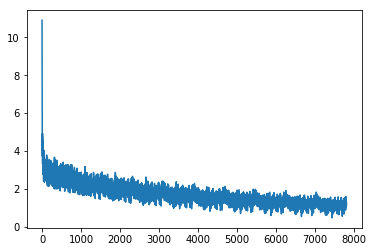

In [97]:
plt.plot(batch_losses)

In [46]:
LSTMCell

tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl.LSTMCell